# HW07 — Clustering (KMeans / DBSCAN / Agglomerative) + Internal Metrics + PCA

Imports + папки

In [3]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score
)

# единый random_state для воспроизводимости (где применимо)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Папки (относительно homeworks/HW07/)
DATA_DIR = Path("data")
ART_DIR  = Path("artifacts")
FIG_DIR  = ART_DIR / "figures"
LBL_DIR  = ART_DIR / "labels"

DATA_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
LBL_DIR.mkdir(parents=True, exist_ok=True)

# 3 датасета (01/02/03)
DATASETS = [
    ("hw07_ds1", "S07-hw-dataset-01.csv"),
    ("hw07_ds2", "S07-hw-dataset-02.csv"),
    ("hw07_ds3", "S07-hw-dataset-03.csv"),
]


## Utils (EDA / preprocessing / metrics / plots)


In [9]:
def basic_eda(df: pd.DataFrame, name: str):
    print("=" * 90)
    print(f"DATASET: {name} | shape={df.shape}")
    display(df.head(5))

    print("\nINFO:")
    print(df.info())

    print("\nDESCRIBE:")
    display(df.describe(include="all").T)

    na_cnt = df.isna().sum().sort_values(ascending=False)
    na_pct = (df.isna().mean() * 100).sort_values(ascending=False).round(2)
    miss = pd.DataFrame({"na_count": na_cnt, "na_%": na_pct})
    miss = miss[miss["na_count"] > 0]
    if len(miss) > 0:
        print("\nMISSING VALUES:")
        display(miss)
    else:
        print("\nMISSING VALUES: нет пропусков")


def build_preprocessor(X: pd.DataFrame):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    if len(cat_cols) > 0:
        cat_pipe = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ])
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", num_pipe, num_cols),
                ("cat", cat_pipe, cat_cols),
            ],
            remainder="drop"
        )
    else:
        preprocessor = ColumnTransformer(
            transformers=[("num", num_pipe, num_cols)],
            remainder="drop"
        )

    return preprocessor, num_cols, cat_cols


def to_dense(Xt):
    return Xt.toarray() if hasattr(Xt, "toarray") else Xt


def internal_metrics(X_emb: np.ndarray, labels: np.ndarray, is_dbscan: bool):
    """
    Возвращает dict:
      silhouette (выше лучше)  - считаем на подвыборке для ускорения
      davies_bouldin (ниже лучше)
      calinski_harabasz (выше лучше)
      noise_share (для DBSCAN)

    Для DBSCAN метрики считаем по non-noise точкам (labels != -1).
    Если метрики посчитать нельзя (мало точек/1 кластер) -> None.
    """
    res = {"silhouette": None, "davies_bouldin": None, "calinski_harabasz": None}

    if is_dbscan:
        mask = labels != -1
        res["noise_share"] = float((~mask).mean())
        X_use = X_emb[mask]
        y_use = labels[mask]
    else:
        res["noise_share"] = 0.0
        X_use = X_emb
        y_use = labels

    # Проверки на валидность метрик
    uniq = np.unique(y_use)
    n_labels = len(uniq)
    n_samples = len(y_use)

    if n_labels < 2:
        return res
    if n_samples <= n_labels:
        return res
    if n_samples < 3:
        return res

    try:
        ss = min(2000, n_samples)
        res["silhouette"] = float(
            silhouette_score(X_use, y_use, sample_size=ss, random_state=RANDOM_STATE)
        )
    except ValueError:
        res["silhouette"] = None

    try:
        res["davies_bouldin"] = float(davies_bouldin_score(X_use, y_use))
    except ValueError:
        res["davies_bouldin"] = None

    try:
        res["calinski_harabasz"] = float(calinski_harabasz_score(X_use, y_use))
    except ValueError:
        res["calinski_harabasz"] = None

    return res


def plot_curve(xs, ys, title, xlabel, ylabel, save_path: Path):
    plt.figure()
    plt.plot(xs, ys, marker="o")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()


def pca_scatter(X_emb: np.ndarray, labels: np.ndarray, title: str, save_path: Path):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(X_emb)

    plt.figure()
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=12)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()


## 2.3.1–2.3.3: EDA + Preprocessing + KMeans



##########################################################################################
PART 1 | DATASET: hw07_ds1 | file=S07-hw-dataset-01.csv
DATASET: hw07_ds1 | shape=(12000, 9)


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB
None

DESCRIBE:


,count,mean,std,min,25%,50%,75%,max
sample_id,12000.0,5999.500000,3464.245950,0.000000,2999.750000,5999.500000,8999.250000,11999.000000
f01,12000.0,-2.424716,11.014315,-19.912573,-9.472623,-6.869404,0.523841,24.403381
f02,12000.0,19.107804,60.790338,-92.892652,-40.282955,54.069335,70.280739,112.229523
f03,12000.0,-0.222063,0.500630,-1.590979,-0.125145,-0.031753,0.054980,0.512277
f04,12000.0,-8.284501,59.269838,-134.303679,-48.345007,16.211728,28.067178,75.088604
f05,12000.0,-0.190717,7.026435,-11.869169,-5.132473,0.444730,3.942368,13.717091
f06,12000.0,0.962972,14.794713,-20.521164,-8.807706,-6.134169,2.334426,41.452857
f07,12000.0,0.033724,59.541782,-215.098834,-39.900520,-0.578494,39.719821,213.381767
f08,12000.0,0.007638,0.607053,-2.633469,-0.401483,0.005306,0.410132,2.490745



MISSING VALUES: нет пропусков

NUM cols: 8 | CAT cols: 0


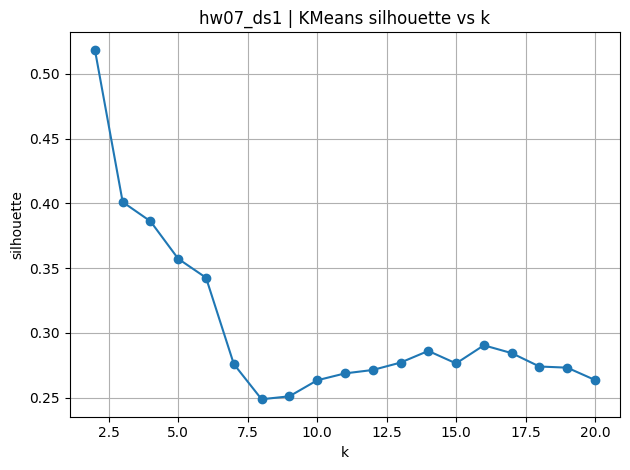

[hw07_ds1] Best KMeans k: 2 | metrics={'silhouette': 0.5185159566612942, 'davies_bouldin': 0.6853295219054457, 'calinski_harabasz': 11786.954622671532, 'noise_share': 0.0}

##########################################################################################
PART 1 | DATASET: hw07_ds2 | file=S07-hw-dataset-02.csv
DATASET: hw07_ds2 | shape=(8000, 4)


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None

DESCRIBE:


,count,mean,std,min,25%,50%,75%,max
sample_id,8000.0,3999.500000,2309.545410,0.000000,1999.750000,3999.500000,5999.250000,7999.000000
x1,8000.0,0.478867,0.955138,-2.487352,-0.116516,0.490658,1.085263,2.987555
x2,8000.0,0.241112,0.663195,-2.499237,-0.242357,0.241092,0.726526,2.995553
z_noise,8000.0,0.110454,8.097716,-34.056074,-5.392210,0.132470,5.655605,29.460076



MISSING VALUES: нет пропусков

NUM cols: 3 | CAT cols: 0


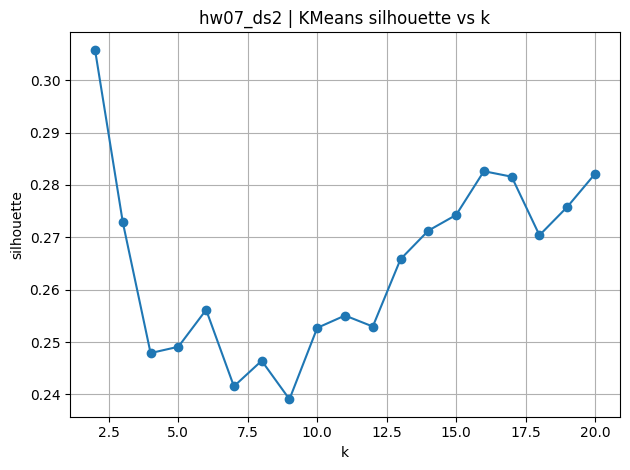

[hw07_ds2] Best KMeans k: 2 | metrics={'silhouette': 0.3057963782011001, 'davies_bouldin': 1.3234721699867644, 'calinski_harabasz': 3573.3933329348392, 'noise_share': 0.0}

##########################################################################################
PART 1 | DATASET: hw07_ds3 | file=S07-hw-dataset-03.csv
DATASET: hw07_ds3 | shape=(15000, 5)


,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB
None

DESCRIBE:


,count,mean,std,min,25%,50%,75%,max
sample_id,15000.0,7499.500000,4330.271354,0.000000,3749.750000,7499.500000,11249.250000,14999.000000
x1,15000.0,1.246296,4.592421,-9.995585,-1.782144,0.664226,4.435671,16.207863
x2,15000.0,1.033764,4.710791,-9.980853,-2.666393,1.831257,4.969630,14.271153
f_corr,15000.0,0.212776,1.530017,-5.212038,-0.966224,0.296508,1.390273,5.795876
f_noise,15000.0,-0.027067,2.506375,-8.785884,-1.731128,-0.052391,1.673831,11.266865



MISSING VALUES: нет пропусков

NUM cols: 4 | CAT cols: 0


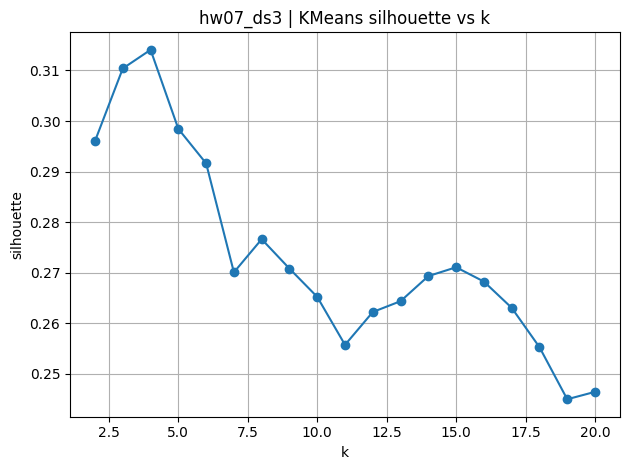

[hw07_ds3] Best KMeans k: 4 | metrics={'silhouette': 0.3140896959261483, 'davies_bouldin': 1.1596756007747973, 'calinski_harabasz': 6492.278930703822, 'noise_share': 0.0}


In [10]:
metrics_summary = {}
dataset_cache = {}   # сюда сложим X_emb и sample_id, чтобы во 2-й ячейке не пересчитывать
kmeans_best = {}     # сюда сложим лучший k по silhouette

for ds_key, fname in DATASETS:
    print("\n" + "#" * 90)
    print(f"PART 1 | DATASET: {ds_key} | file={fname}")

    df = pd.read_csv(DATA_DIR / fname)

    # EDA
    basic_eda(df, ds_key)

    if "sample_id" not in df.columns:
        raise ValueError(f"{fname}: нет колонки sample_id")

    sample_id = df["sample_id"].copy()
    X = df.drop(columns=["sample_id"])

    # Preprocess
    preprocessor, num_cols, cat_cols = build_preprocessor(X)
    print(f"\nNUM cols: {len(num_cols)} | CAT cols: {len(cat_cols)}")

    X_emb = to_dense(preprocessor.fit_transform(X))

    dataset_cache[ds_key] = {
        "sample_id": sample_id,
        "X_emb": X_emb,
        "cat_cols_count": len(cat_cols)
    }

    metrics_summary[ds_key] = {}

    # ---- KMeans search k=2..20
    k_values = list(range(2, 21))
    sil_values = []

    best_k = None
    best_s = -np.inf
    best_m = None

    for k in k_values:
        # ускорение: n_init=5 на подборе
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=5)
        labels = km.fit_predict(X_emb)

        m = internal_metrics(X_emb, labels, is_dbscan=False)
        metrics_summary[ds_key][f"kmeans_k={k}"] = m

        s = m["silhouette"]
        sil_values.append(s if s is not None else np.nan)

        if s is not None and s > best_s:
            best_s = s
            best_k = k
            best_m = m

    plot_curve(
        k_values, sil_values,
        title=f"{ds_key} | KMeans silhouette vs k",
        xlabel="k", ylabel="silhouette",
        save_path=FIG_DIR / f"{ds_key}_kmeans_silhouette_vs_k.png"
    )

    # fallback если вдруг всё None
    if best_k is None:
        best_k = 2
        best_m = {"silhouette": None, "davies_bouldin": None, "calinski_harabasz": None, "noise_share": 0.0}

    kmeans_best[ds_key] = {
        "k": best_k,
        "metrics": best_m
    }

    print(f"[{ds_key}] Best KMeans k: {best_k} | metrics={best_m}")


## 2.3.3–2.3.7: DBSCAN + Metrics + Best model + PCA + Artifacts


##########################################################################################
PART 2 | DATASET: hw07_ds1


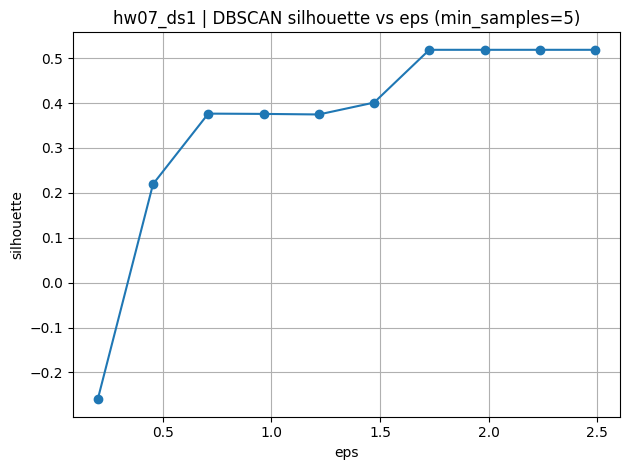


[hw07_ds1] BEST MODEL: kmeans
params: {'n_clusters': 2, 'random_state': 42, 'n_init': 10}
metrics: {'silhouette': 0.5185159566612942, 'davies_bouldin': 0.6853295219054457, 'calinski_harabasz': 11786.954622671532, 'noise_share': 0.0}


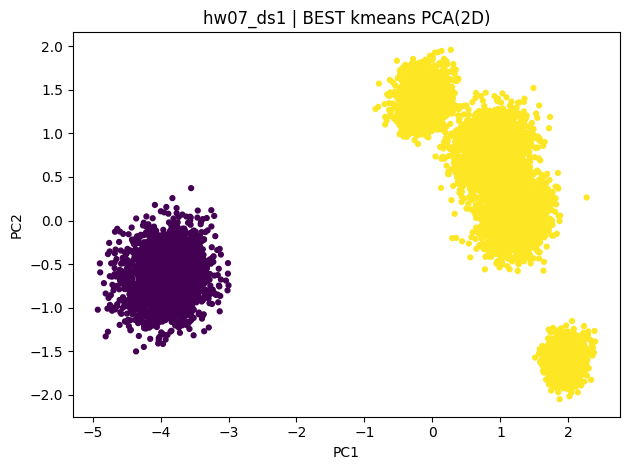


ИТОГ :
- Датасет: hw07_ds1
- Препроцессинг: SimpleImputer(median) + StandardScaler; cat: нет
- Сравнили: KMeans(k=2..20) + DBSCAN(eps/min_samples)
- Лучшее: kmeans {'n_clusters': 2, 'random_state': 42, 'n_init': 10}
- Silhouette/DB/CH: 0.5185159566612942 / 0.6853295219054457 / 11786.954622671532

##########################################################################################
PART 2 | DATASET: hw07_ds2


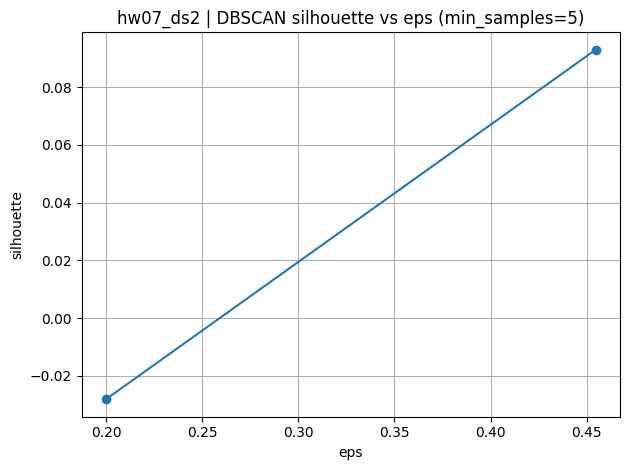


[hw07_ds2] BEST MODEL: dbscan
params: {'eps': 0.709090909090909, 'min_samples': 3}
metrics: {'silhouette': 0.32888382326608556, 'davies_bouldin': 0.5510099327721495, 'calinski_harabasz': 10.404304748515782, 'noise_share': 0.007}


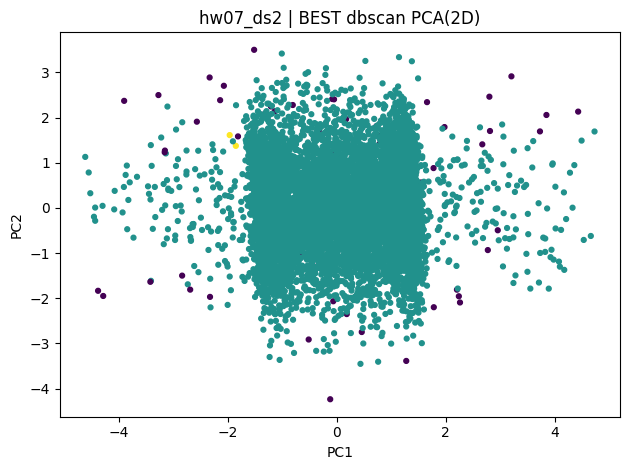


ИТОГ :
- Датасет: hw07_ds2
- Препроцессинг: SimpleImputer(median) + StandardScaler; cat: нет
- Сравнили: KMeans(k=2..20) + DBSCAN(eps/min_samples)
- Лучшее: dbscan {'eps': 0.709090909090909, 'min_samples': 3}
- Silhouette/DB/CH: 0.32888382326608556 / 0.5510099327721495 / 10.404304748515782
- Noise share (DBSCAN): 0.007

##########################################################################################
PART 2 | DATASET: hw07_ds3


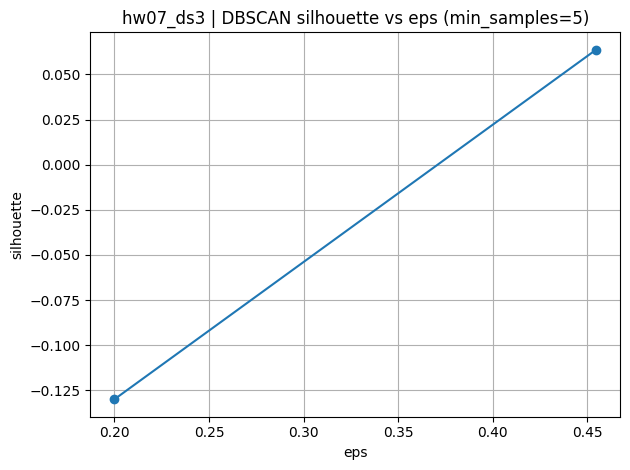


[hw07_ds3] BEST MODEL: kmeans
params: {'n_clusters': 4, 'random_state': 42, 'n_init': 10}
metrics: {'silhouette': 0.3140896959261483, 'davies_bouldin': 1.1596756007747973, 'calinski_harabasz': 6492.278930703822, 'noise_share': 0.0}


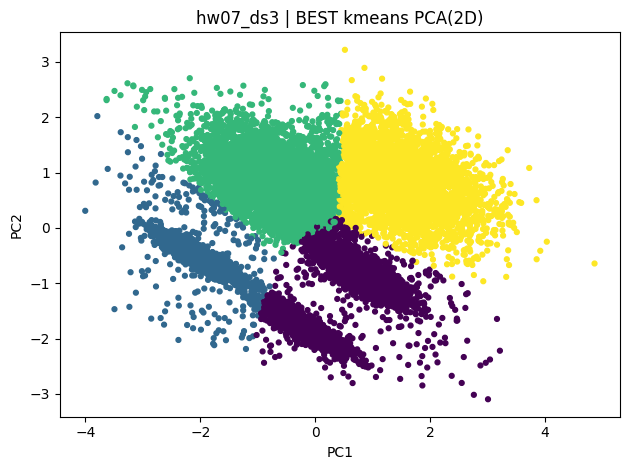


ИТОГ :
- Датасет: hw07_ds3
- Препроцессинг: SimpleImputer(median) + StandardScaler; cat: нет
- Сравнили: KMeans(k=2..20) + DBSCAN(eps/min_samples)
- Лучшее: kmeans {'n_clusters': 4, 'random_state': 42, 'n_init': 10}
- Silhouette/DB/CH: 0.3140896959261483 / 1.1596756007747973 / 6492.278930703822
SAVED JSON:
- artifacts\metrics_summary.json
- artifacts\best_configs.json


In [13]:
best_configs = {}

for ds_key, _ in DATASETS:
    print("\n" + "#" * 90)
    print(f"PART 2 | DATASET: {ds_key}")

    X_emb = dataset_cache[ds_key]["X_emb"]
    sample_id = dataset_cache[ds_key]["sample_id"]
    cat_cnt = dataset_cache[ds_key]["cat_cols_count"]

    # ---- DBSCAN search
    eps_grid = np.linspace(0.2, 3.0, 12)   # было 15
    min_samples_grid = [3, 5, 10]

    dbscan_x = []
    dbscan_sil = []

    best_dbscan_score = -np.inf
    best_dbscan_params = None
    best_dbscan_metrics = None

    for ms in min_samples_grid:
        for eps in eps_grid:
            db = DBSCAN(eps=float(eps), min_samples=int(ms))
            labels = db.fit_predict(X_emb)

            m = internal_metrics(X_emb, labels, is_dbscan=True)
            metrics_summary[ds_key][f"dbscan_eps={eps:.2f}_ms={ms}"] = m

            s = m["silhouette"]

            if ms == 5:
                dbscan_x.append(float(eps))
                dbscan_sil.append(s if s is not None else np.nan)

            if s is not None:
                score = s - 0.2 * m.get("noise_share", 0.0)
                if score > best_dbscan_score:
                    best_dbscan_score = score
                    best_dbscan_params = {"eps": float(eps), "min_samples": int(ms)}
                    best_dbscan_metrics = m

    plot_curve(
        dbscan_x, dbscan_sil,
        title=f"{ds_key} | DBSCAN silhouette vs eps (min_samples=5)",
        xlabel="eps", ylabel="silhouette",
        save_path=FIG_DIR / f"{ds_key}_dbscan_silhouette_vs_eps_ms5.png"
    )

    # ---- compare best KMeans vs best DBSCAN
    k = kmeans_best[ds_key]["k"]
    km_metrics = kmeans_best[ds_key]["metrics"]
    km_score = km_metrics["silhouette"] if km_metrics["silhouette"] is not None else -np.inf
    db_score = best_dbscan_score if best_dbscan_params is not None else -np.inf

    if db_score > km_score:
        best_model = "dbscan"
        best_params = best_dbscan_params
        best_m = best_dbscan_metrics
        best_labels = DBSCAN(**best_params).fit_predict(X_emb)
    else:
        best_model = "kmeans"
        best_params = {"n_clusters": int(k), "random_state": RANDOM_STATE, "n_init": 10}
        km = KMeans(**best_params)
        best_labels = km.fit_predict(X_emb)
        best_m = internal_metrics(X_emb, best_labels, is_dbscan=False)

    best_configs[ds_key] = {
        "best_model": best_model,
        "best_params": best_params,
        "selection_rule": "compare: KMeans silhouette vs DBSCAN (silhouette - 0.2*noise_share)"
    }

    print(f"\n[{ds_key}] BEST MODEL: {best_model}")
    print(f"params: {best_params}")
    print(f"metrics: {best_m}")

    # ---- PCA scatter for best
    pca_scatter(
        X_emb, best_labels,
        title=f"{ds_key} | BEST {best_model} PCA(2D)",
        save_path=FIG_DIR / f"{ds_key}_best_pca_scatter.png"
    )

    # ---- save labels csv
    out = pd.DataFrame({"sample_id": sample_id, "cluster_label": best_labels})
    out.to_csv(LBL_DIR / f"labels_{ds_key}.csv", index=False)

    print("\nИТОГ :")
    print(f"- Датасет: {ds_key}")
    print(f"- Препроцессинг: SimpleImputer(median) + StandardScaler; cat: {'нет' if cat_cnt==0 else 'есть (но для 01/02/03 обычно 0)'}")
    print(f"- Сравнили: KMeans(k=2..20) + DBSCAN(eps/min_samples)")
    print(f"- Лучшее: {best_model} {best_params}")
    print(f"- Silhouette/DB/CH: {best_m.get('silhouette')} / {best_m.get('davies_bouldin')} / {best_m.get('calinski_harabasz')}")
    if best_model == "dbscan":
        print(f"- Noise share (DBSCAN): {best_m.get('noise_share')}")

with open(ART_DIR / "metrics_summary.json", "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, ensure_ascii=False, indent=2)

with open(ART_DIR / "best_configs.json", "w", encoding="utf-8") as f:
    json.dump(best_configs, f, ensure_ascii=False, indent=2)

print("SAVED JSON:")
print("-", ART_DIR / "metrics_summary.json")
print("-", ART_DIR / "best_configs.json")


## Stability (KMeans, 5 runs, ARI)

STABILITY: hw07_ds1 | KMeans k=2
Mean ARI (off-diagonal): 1.0


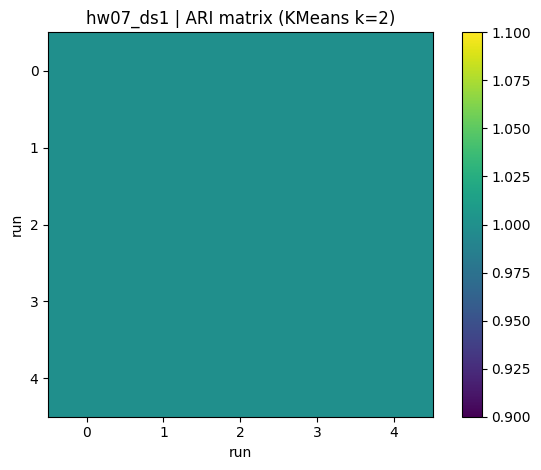

In [14]:
stable_ds_key = DATASETS[0][0]  # например hw07_ds1

X_emb = dataset_cache[stable_ds_key]["X_emb"]

# берём лучший k из подбора KMeans
k = int(kmeans_best[stable_ds_key]["k"])

seeds = [0, 1, 2, 3, 4]
labels_list = []

for rs in seeds:
    km = KMeans(n_clusters=k, random_state=rs, n_init=10)
    labels_list.append(km.fit_predict(X_emb))

n = len(seeds)
ari_mat = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        ari_mat[i, j] = adjusted_rand_score(labels_list[i], labels_list[j])

mean_ari = ari_mat[~np.eye(n, dtype=bool)].mean()

print(f"STABILITY: {stable_ds_key} | KMeans k={k}")
print("Mean ARI (off-diagonal):", float(mean_ari))

plt.figure()
plt.imshow(ari_mat)
plt.title(f"{stable_ds_key} | ARI matrix (KMeans k={k})")
plt.xlabel("run")
plt.ylabel("run")
plt.colorbar()
plt.tight_layout()
plt.savefig(FIG_DIR / f"{stable_ds_key}_stability_ari_matrix.png", dpi=150)
plt.show()


# Вывод


### Итог по датасету hw07_ds1 (2.3.7)

- Лучшее решение: **KMeans, k=2** (silhouette ≈ **0.519**, DB ≈ **0.685**, CH ≈ **11786**).
- По графику silhouette vs k максимум достигается при **k=2**, дальше качество падает.
- На PCA(2D) видно два компактных и хорошо отделимых «шарообразных» облака — это типичная геометрия для KMeans.
- В датасете нет пропусков и категориальных признаков, поэтому достаточно числового препроцессинга.
- Важный момент: признаки в разных шкалах (по условию датасета), поэтому **StandardScaler критичен**, иначе расстояния “перекосились” бы.
- DBSCAN пробовали как альтернативу, но выигрыш не дал при подборе eps, а интерпретация хуже.
- Проверка устойчивости: для KMeans (k=2) при 5 random_state **Mean ARI = 1.0**, разбиение полностью стабильное.


### Итог по датасету hw07_ds2 (2.3.7)

- Лучшее решение: **DBSCAN (eps ≈ 0.709, min_samples = 3)**.
- Метрики для выбранного решения: silhouette ≈ **0.329**, доля шума (noise_share) ≈ **0.007** (≈0.7% точек).
- Датасет содержит нелинейную структуру и выбросы/шум (по условию), поэтому KMeans, ориентированный на «шарообразные» кластеры, не всегда адекватен.
- DBSCAN лучше подходит, потому что выделяет **плотные области** и умеет помечать выбросы как **noise = -1**.
- Подбор eps чувствителен: при малых eps часть точек уходит в шум/кластеры дробятся; при больших eps кластеры могут сливаться.
- В итоге выбран параметр, дающий лучший баланс по метрикам и малую долю шума.
- PCA(2D) визуализация подтверждает, что выделенные группы выглядят согласованно, а редкие точки ведут себя как выбросы.


### Итог по датасету hw07_ds3 (2.3.7)

- Лучшее решение: **KMeans, k=4** (silhouette ≈ **0.314**, DB ≈ **1.160**, CH ≈ **6492**).
- По условию датасета ожидаются кластеры разной плотности и фоновый шум: это усложняет подбор параметров DBSCAN (один eps плохо подходит всем плотностям).
- В нашем переборе DBSCAN не показал устойчивого улучшения: значения silhouette для DBSCAN по eps были низкими/нестабильными, поэтому выбор сделан в пользу KMeans.
- KMeans даёт более предсказуемое разбиение при фиксированном k и обеспечивает приемлемое качество по внутренним метрикам.
- На PCA(2D) видны несколько групп, но границы местами “смазаны” — это ожидаемо при шуме и разной плотности.
- Основная сложность: компромисс между “пересегментацией” (слишком много мелких кластеров) и “слипанием” близких областей.
- Итоговый выбор — наиболее стабильная и интерпретируемая конфигурация в рамках сравниваемых методов.


# Сравнение алгоритмов

**KMeans**
- Сильные стороны: быстро работает, стабилен при фиксированном `random_state`, хорошо подходит для компактных «шарообразных» кластеров.
- Слабые стороны: плохо справляется с нелинейными формами и выбросами; требует выбора `k`.
- По результатам HW07: отлично подошёл для **hw07_ds1**, дал приемлемый компромисс для **hw07_ds3**.

**DBSCAN**
- Сильные стороны: умеет выделять кластеры произвольной формы, устойчивее к выбросам (помечает noise = -1), не требует задавать `k`.
- Слабые стороны: чувствителен к `eps` и `min_samples`, особенно при разной плотности кластеров; может давать 1 кластер или много шума.
- По результатам HW07: лучше всего проявил себя на **hw07_ds2** (нелинейность + выбросы), но оказался менее стабильным на **hw07_ds3** (разная плотность).


# Общие выводы

- Для честного unsupervised-эксперимента критично делать единый и явный препроцессинг: **imputer + StandardScaler** (и кодирование категориальных, если бы они были).
- Внутренние метрики (silhouette/DB/CH) помогают сравнивать конфиги без истинных меток, но их важно интерпретировать вместе с визуализацией (PCA).
- На данных с “шарообразными” кластерами KMeans даёт лучшее и более стабильное решение (пример: **hw07_ds1**, что подтверждается и устойчивостью ARI).
- Для нелинейных структур и выбросов DBSCAN часто уместнее, так как выделяет плотные области и отделяет шум (пример: **hw07_ds2**).
- При разной плотности и шуме подбор DBSCAN становится сложнее (пример: **hw07_ds3**), поэтому иногда разумнее выбрать более стабильный подход и честно зафиксировать ограничения.
